# <font color = lightcoral>Understand current parsing and windowing logic and device new one
>    
### <font color = red>Interleaved Sliding Window - Non Overlapping
> this is the case where every 10th period is part of the test set, whereas data from periods 1-8 are part of the train set

## <font color = grey> Admin

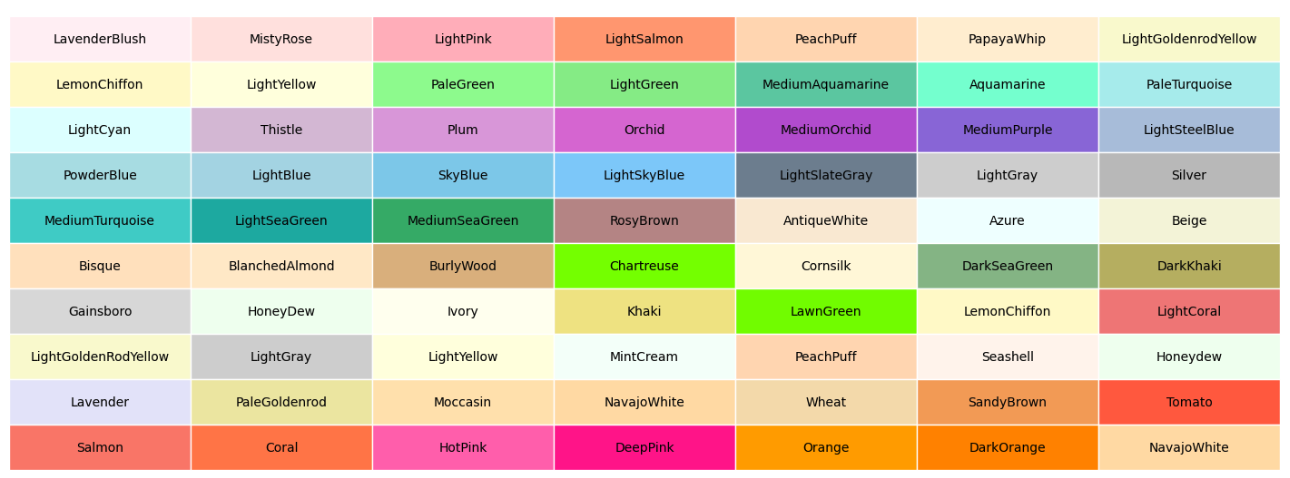

In [1]:
import pandas as pd
import os
import gzip
import time
import warnings
import os
import shutil
from datetime import datetime
# Set display option to show the full length of the column
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

In [2]:
# Determine the base directory based on the effective user ID
if os.geteuid() == 0:  # root user
    base_dir = '/root'
else:
    base_dir = '/home/sagemaker-user'

# Set the environment variable
os.environ['BASE_DIR'] = base_dir

# Verify the base directory
print(f"Base directory set to: {base_dir}")

Base directory set to: /home/sagemaker-user


___
# <font color = darkkhaki> (B) EDA

## <font color = lightsteelblue>EDA of Template File

In [ ]:
# !cd /home/ubuntu/efs-w210-capstone-ebs/08.GIT_Repos_Anomaly_Detection/23.Library_Transformers_Logbert_HelenG_BGL/output/bgl

In [ ]:
# import pandas as pd
# import time

# # Define the path to the CSV file
# # file_path = "/root/08.GIT_Repos_REF/23.Library_Transformers_Logbert_HelenG_BGL/output/bgl/BGL.log_templates.csv"

# # file_path = "/root/mnt/efs-w210-capstone/200015/08.GIT_Repos_REF/23.Library_Transformers_Logbert_HelenG_BGL/output/bgl/BGL.log_templates.csv"

# # file_path = os.path.join(base_dir, '/home/ubuntu/efs-w210-capstone-ebs/08.GIT_Repos_Anomaly_Detection/23.Library_Transformers_Logbert_HelenG_BGL/output/bgl/BGL.log_templates.csv')
# file_path = os.path.join(base_dir,'/home/ubuntu/efs-w210-capstone-ebs/11.Data/01.BGL/09.20240704_parsed_bgl/BGL.log_templates.csv')



# # /mnt/efs-w210-capstone/200015/

# # Start timing
# start_time = time.time()

# # Read the CSV file
# df = pd.read_csv(file_path)

# # Section 1: Preview
# print("\n" + "*"*100)
# print("********************** Section 1: Preview ******************************************")
# print("*"*100 + "\n")
# display(df.head())

# # Section 2: Shape of the DataFrame
# print("\n" + "*"*100)
# print("********************** Section 2: Shape of the DataFrame ****************************")
# print("*"*100 + "\n")
# print(df.shape)

# # Section 3: DataFrame Information
# print("\n" + "*"*100)
# print("********************** Section 3: DataFrame Information ****************************")
# print("*"*100 + "\n")
# print(df.info())

# # Section 4: Summary Statistics (without scientific notation)
# print("\n" + "*"*100)
# print("********************** Section 4: Summary Statistics *******************************")
# print("*"*100 + "\n")
# pd.options.display.float_format = '{:,.0f}'.format
# print(df.describe())

# # Section 5: Unique Event IDs
# print("\n" + "*"*100)
# print("********************** Section 5: Unique Event IDs *********************************")
# print("*"*100 + "\n")
# print(df['EventId'].nunique())

# # Section 7: Most Frequent Event Templates with Counts (ordered by occurrences)
# print("\n" + "*"*100)
# print("********************** Section 7: Most Frequent Event Templates *********************")
# print("*"*100 + "\n")
# df_sorted = df.sort_values(by='Occurrences', ascending=False).reset_index()
# df_sorted.index += 1  # Make the index start from 1
# df_sorted.rename(columns={'index': 'RowNum'}, inplace=True)
# print(df_sorted[['EventId', 'RowNum', 'EventTemplate', 'Occurrences']].head())

# # Section 8: Relevant Statistics
# print("\n" + "*"*100)
# print("********************** Section 8: Relevant Statistics *******************************")
# print("*"*100 + "\n")

# # Total number of events
# total_events = df['Occurrences'].sum()
# print(f"Total number of events: {total_events}")

# # Average occurrences per event template
# average_occurrences = df['Occurrences'].mean()
# print(f"Average occurrences per event template: {average_occurrences:.2f}")

# # Maximum occurrences of a single event template
# max_occurrences = df['Occurrences'].max()
# max_event_template = df[df['Occurrences'] == max_occurrences]['EventTemplate'].values[0]
# print(f"Maximum occurrences of a single event template: {max_occurrences} (Event Template: {max_event_template})")

# # Minimum occurrences of a single event template
# min_occurrences = df['Occurrences'].min()
# min_event_template = df[df['Occurrences'] == min_occurrences]['EventTemplate'].values[0]
# print(f"Minimum occurrences of a single event template: {min_occurrences} (Event Template: {min_event_template})")

# # End timing
# end_time = time.time()
# duration = end_time - start_time
# print("\n" + "_"*100)
# print(f"\nTime taken: {duration:.2f} seconds")
# print("\n" + "_"*100)

___
# <font color = darkkhaki> (C) EDA

## <font color = lightsteelblue>EDA of Parsed File

---

In [ ]:
# import pandas as pd
# import time

# # Define the path to the CSV file
# # file_path = "/root/08.GIT_Repos_REF/23.Library_Transformers_Logbert_HelenG_BGL/output/bgl/BGL.log_structured.csv"

# # file_path = os.path.join(base_dir, '/mnt/efs-w210-capstone/200015/08.GIT_Repos_Anomaly_Detection/23.Library_Transformers_Logbert_HelenG_BGL/output/bgl/BGL.log_structured.csv')
# # file_path = os.path.join(base_dir, '/home/ubuntu/efs-w210-capstone-ebs/08.GIT_Repos_Anomaly_Detection/23.Library_Transformers_Logbert_HelenG_BGL/output/bgl/20240701_BGL_Log_Structuted_v1.00.csv')
# # file_path = os.path.join(base_dir,'/home/ubuntu/efs-w210-capstone-ebs/11.Data/01.BGL/09.20240704_parsed_bgl/BGL.log_structured.csv')
# file_path = os.path.join(base_dir,'/home/ubuntu/efs-w210-capstone-ebs/11.Data/01.BGL/09.20240704_parsed_bgl/BGL_Sample.log_structured.csv')

# # Start timing
# start_time = time.time()

# # Read the CSV file
# df = pd.read_csv(file_path)

# # Section 1: Preview
# print("\n" + "*"*100)
# print("********************** Section 1: Preview ******************************************")
# print("*"*100 + "\n")
# display(df.head())

# # Section 2: Shape of the DataFrame
# print("\n" + "*"*100)
# print("********************** Section 2: Shape of the DataFrame ****************************")
# print("*"*100 + "\n")
# print(df.shape)

# # Section 3: DataFrame Information
# print("\n" + "*"*100)
# print("********************** Section 3: DataFrame Information ****************************")
# print("*"*100 + "\n")
# print(df.info())

# # Section 4: Summary Statistics (without scientific notation)
# print("\n" + "*"*100)
# print("********************** Section 4: Summary Statistics *******************************")
# print("*"*100 + "\n")
# pd.options.display.float_format = '{:,.0f}'.format
# print(df.describe())

# # Section 5: Unique Event Templates
# print("\n" + "*"*100)
# print("********************** Section 5: Unique Event Templates ***************************")
# print("*"*100 + "\n")
# print(df['EventTemplate'].nunique())

# # Section 6: Count of Each Event Template
# print("\n" + "*"*100)
# print("********************** Section 6: Count of Each Event Template *********************")
# print("*"*100 + "\n")
# print(df['EventTemplate'].value_counts().head())

# # Section 7: Most Frequent Event Templates with Counts (ordered by occurrences)
# print("\n" + "*"*100)
# print("********************** Section 7: Most Frequent Event Templates *********************")
# print("*"*100 + "\n")
# df_sorted = df.groupby(['EventId', 'EventTemplate']).size().reset_index(name='Occurrences')
# df_sorted = df_sorted.sort_values(by='Occurrences', ascending=False).reset_index(drop=True)
# df_sorted.index += 1  # Make the index start from 1
# print(df_sorted.head())

# # Section 8: Alert Analysis
# print("\n" + "*"*100)
# print("********************** Section 8: Alert Analysis ************************************")
# print("*"*100 + "\n")

# # Count of normal vs alert logs
# label_counts = df['Label'].value_counts()
# print(f"Normal logs: {label_counts.get('-', 0)}")
# print(f"Alert logs: {label_counts.sum() - label_counts.get('-', 0)}")

# # Most frequent labels for alerts
# alert_labels = df[df['Label'] != '-']['Label'].value_counts().head()
# print("\nMost frequent alert labels:")
# print(alert_labels)

# # Distribution of alert levels
# alert_levels = df[df['Label'] != '-']['Level'].value_counts()
# print("\nDistribution of alert levels:")
# print(alert_levels)

# # Section 9: Label and Alert Level Analysis
# print("\n" + "*"*100)
# print("********************** Section 9: Label and Alert Level Analysis ********************")
# print("*"*100 + "\n")

# # Distribution of values in the Label column with an indicator for normal or alert
# df['LogType'] = df['Label'].apply(lambda x: 'Normal' if x == '-' else 'Alert')
# label_distribution = df.groupby(['LogType', 'Label']).size()
# print("\nDistribution of values in the Label column with an indicator for normal or alert:")
# display(label_distribution)

# # Distribution of values in the Level column for alerts
# alert_level_distribution = df[df['LogType'] == 'Alert'].groupby('Level').size().reset_index(name='count')
# alert_level_distribution['LogType'] = 'Alert'
# print("\nDistribution of values in the Level column for alerts:")
# display(alert_level_distribution[['LogType', 'Level', 'count']])

# # Distribution of values in the Level column for normal logs with an indicator for normal or alert
# normal_level_distribution = df[df['LogType'] == 'Normal'].groupby('Level').size().reset_index(name='count')
# normal_level_distribution['LogType'] = 'Normal'
# print("\nDistribution of values in the Level column for normal logs with an indicator for normal or alert:")
# display(normal_level_distribution[['LogType', 'Level', 'count']])

# # Section 10: Combined LogType, Label, Level, and Count
# print("\n" + "*"*100)
# print("********************** Section 10: Combined LogType, Label, Level, and Count ********")
# print("*"*100 + "\n")

# combined_distribution = df.groupby(['LogType', 'Label', 'Level']).size().reset_index(name='count')
# combined_distribution = combined_distribution.sort_values(by=['LogType', 'count', 'Label'], ascending=[False, False, True])
# display(combined_distribution)

# # Section 11: Count Unique Values in Each Column
# print("\n" + "*"*100)
# print("********************** Section 11: Count Unique Values in Each Column ****************")
# print("*"*100 + "\n")
# print(df.nunique())

# # Section 12: Random Sample of 10 Alert Rows
# print("\n" + "*"*100)
# print("********************** Section 12: Random Sample of 10 Alert Rows ********************")
# print("*"*100 + "\n")
# alert_rows = df[df['Label'] != '-']
# sample_alert_rows = alert_rows.sample(n=10) if len(alert_rows) >= 10 else alert_rows
# display(sample_alert_rows)

# # Section 13: Analysis of Rows for Normal and Alert Labels
# print("\n" + "*"*100)
# print("********************** Section 13: Analysis of Rows for Normal and Alert Labels ********")
# print("*"*100 + "\n")

# # Grouping by LogType to count rows for Normal and Alert logs
# logtype_counts = df['LogType'].value_counts()
# total_logs = logtype_counts.sum()
# normal_percentage = (logtype_counts['Normal'] / total_logs) * 100
# alert_percentage = (logtype_counts['Alert'] / total_logs) * 100

# print(f"Normal logs: {logtype_counts['Normal']} ({normal_percentage:.2f}%)")
# print(f"Alert logs: {logtype_counts['Alert']} ({alert_percentage:.2f}%)")

# # End timing
# end_time = time.time()
# duration = end_time - start_time
# print("\n" + "_"*100)
# print(f"\nTime taken: {duration:.2f} seconds")
# print("\n" + "_"*100)

---

___
# <font color = darkkhaki> (D). Data Prep --> Create sample for sanity testing

In [ ]:
# import pandas as pd

# # Load the data
# data_dir = '/home/ubuntu/efs-w210-capstone-ebs/11.Data/01.BGL/09.20240704_parsed_bgl'
# input_file = f"{data_dir}/20240704__full__new_features_v1.10.parquet"
# df = pd.read_parquet(input_file)

# # Split the data
# train_size = int(0.8 * len(df))
# train_df = df[:train_size]
# test_df = df[train_size:]

# # Save the splits
# train_output_file = f"{data_dir}/20240704__train__new_features_v1.10.parquet"
# test_output_file = f"{data_dir}/20240704__test__new_features_v1.10.parquet"

# train_df.to_parquet(train_output_file)
# test_df.to_parquet(test_output_file)

In [7]:
import pandas as pd

# Paths

####################### Full Base ######################################
# data_dir = '/home/ubuntu/efs-w210-capstone-ebs/11.Data/01.BGL/10.20240705_StartOver_NewFeatures/01.Full_Base/'
# input_file = f"{data_dir}/20240704__full__new_features_v1.10.parquet"

####################### Sample Base ######################################
data_dir = '/home/ubuntu/efs-w210-capstone-ebs/11.Data/01.BGL/10.20240705_StartOver_NewFeatures/03.Sample_Base/'
input_file = f"{data_dir}/20240704__sample__new_features_v1.30.parquet"

####################### Full Test_Train ######################################
# data_dir = '/home/ubuntu/efs-w210-capstone-ebs/11.Data/01.BGL/10.20240705_StartOver_NewFeatures/02.Full_Train_Test/'
# input_file = f"{data_dir}/20240704__train__new_features_v1.10.parquet"
# input_file = f"{data_dir}/20240704__test__new_features_v1.10.parquet"

####################### Sample Test_Train ######################################
# data_dir = '/home/ubuntu/efs-w210-capstone-ebs/11.Data/01.BGL/10.20240705_StartOver_NewFeatures/04.Sample_Train_Test/'
# input_file = f"{data_dir}/20240705_train_claude.parquet"
# input_file = f"{data_dir}/20240705_test_claude.parquet"
# input_file = f"{data_dir}/X_train.parquet"

# Read the parquet file
df = pd.read_parquet(input_file)

# Count the number of rows
row_count = len(df)

print("*"*100 + "\n")
print("************************************** # Rows ********************************")

print(f"The number of rows in the parquet file is: {row_count}")

# print("*"*100 + "\n")
print("************************************** Distinct Records by Class ****************")

# Count the number of distinct records by Class
distinct_class_counts = df['Class'].value_counts()

print(f"The count of distinct records by Class is:\n{distinct_class_counts}")

print("************************************** Shape ***************************")

print(df.shape)

print("************************************** Columns *************************")

print(df.columns)

# print("*"*100 + "\n")
print("************************************** Display Sample ********************************")

# Select the first 8 columns (assuming they exist)
first_eight_columns = df.iloc[:, :12]  # Use indexing for columns

# Display the first few rows of the selected columns
display(first_eight_columns.head(5))

****************************************************************************************************

************************************** # Rows ********************************
The number of rows in the parquet file is: 100
************************************** Distinct Records by Class ****************
The count of distinct records by Class is:
Class
0    81
1    19
Name: count, dtype: int64
************************************** Shape ***************************
(100, 35440)
************************************** Columns *************************
Index(['time_start', 'time_start_int', 'Class', 'unique_events',
       'most_frequent_event', 'transitions', 'entropy', 'EventId_1',
       'EventId_2', 'EventId_3',
       ...
       'EventId_35424', 'EventId_35425', 'EventId_35426', 'EventId_35427',
       'EventId_35428', 'EventId_35429', 'EventId_35430', 'EventId_35431',
       'EventId_35432', 'EventId_35433'],
      dtype='object', length=35440)
**********************************

,time_start,time_start_int,Class,unique_events,most_frequent_event,transitions,entropy,EventId_1,EventId_2,EventId_3,EventId_4,EventId_5
0,2005-06-03 15:40:00,0,0,1,228,0,0.000000,228,228,228,228,228
1,2005-06-03 15:45:00,1,0,2,228,2,0.005288,228,228,228,228,228
2,2005-06-03 15:50:00,2,0,3,228,14,0.073091,228,228,228,228,228
3,2005-06-03 15:55:00,3,0,1,228,0,0.000000,228,228,228,228,228
4,2005-06-03 16:00:00,4,0,6,228,6,0.171708,228,228,228,228,228


----

___
# <font color = darkkhaki> Feature Engg - Chat GPT

### <font color = grey> Prepare Train and Test Files

In [9]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix

####################### Full Base ######################################
# data_dir = '/home/ubuntu/efs-w210-capstone-ebs/11.Data/01.BGL/10.20240705_StartOver_NewFeatures/01.Full_Base/'
# input_file = f"{data_dir}/20240704__full__new_features_v1.10.parquet"
# output_dir = '/home/ubuntu/efs-w210-capstone-ebs/11.Data/01.BGL/10.20240705_StartOver_NewFeatures/02.Full_Train_Test'

####################### Sample Base ######################################
data_dir = '/home/ubuntu/efs-w210-capstone-ebs/11.Data/01.BGL/10.20240705_StartOver_NewFeatures/03.Sample_Base/'
input_file = f"{data_dir}/20240704__sample__new_features_v1.30.parquet"
output_dir = '/home/ubuntu/efs-w210-capstone-ebs/11.Data/01.BGL/10.20240705_StartOver_NewFeatures/04.Sample_Train_Test'

# Load the data
data = pd.read_parquet(input_file)

# Define the columns to use
feature_columns = [col for col in data.columns if col not in ['time_start', 'time_start_int', 'Class']]

# Create windows of data for training and testing
def create_windows(data, window_size=10, gap=1, pred_size=1):
    X, y = [], []
    max_time_int = data['time_start_int'].max()
    
    for start in range(0, max_time_int - window_size - gap - pred_size + 1):
        end = start + window_size
        pred_end = end + gap + pred_size
        
        window_data = data[(data['time_start_int'] >= start) & (data['time_start_int'] < end)]
        pred_data = data[(data['time_start_int'] >= end + gap) & (data['time_start_int'] < pred_end)]
        
        # Debugging statements to check the window sizes
        print(f"start: {start}, end: {end}, pred_end: {pred_end}")
        print(f"window_data shape: {window_data.shape}, pred_data shape: {pred_data.shape}")
        
        if len(pred_data) > 0 and len(window_data) == window_size:
            X.append(window_data[feature_columns].values.flatten())
            y.append(pred_data['Class'].values[0])
    
    return np.array(X), np.array(y)

# Split data into training and testing sets (80% train, 20% test)
split_index = int(len(data) * 0.8)
train_data = data[:split_index]
test_data = data[split_index:]

# Create windows
X_train, y_train = create_windows(train_data)
X_test, y_test = create_windows(test_data)

# Check the shapes of the resulting arrays
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

# Ensure the arrays are not empty
if X_train.size == 0 or y_train.size == 0 or X_test.size == 0 or y_test.size == 0:
    raise ValueError("One of the generated arrays is empty. Please check the data and window creation process.")

# Save the split data
train_output_file = f"{output_dir}/train_data.parquet"
test_output_file = f"{output_dir}/test_data.parquet"
pd.DataFrame(X_train).to_parquet(train_output_file)
pd.DataFrame(X_test).to_parquet(test_output_file)

start: 0, end: 10, pred_end: 12
window_data shape: (9, 35440), pred_data shape: (0, 35440)
start: 1, end: 11, pred_end: 13
window_data shape: (9, 35440), pred_data shape: (1, 35440)
start: 2, end: 12, pred_end: 14
window_data shape: (8, 35440), pred_data shape: (1, 35440)
start: 3, end: 13, pred_end: 15
window_data shape: (8, 35440), pred_data shape: (1, 35440)
start: 4, end: 14, pred_end: 16
window_data shape: (8, 35440), pred_data shape: (1, 35440)
start: 5, end: 15, pred_end: 17
window_data shape: (8, 35440), pred_data shape: (0, 35440)
start: 6, end: 16, pred_end: 18
window_data shape: (8, 35440), pred_data shape: (1, 35440)
start: 7, end: 17, pred_end: 19
window_data shape: (7, 35440), pred_data shape: (0, 35440)
start: 8, end: 18, pred_end: 20
window_data shape: (7, 35440), pred_data shape: (0, 35440)
start: 9, end: 19, pred_end: 21
window_data shape: (7, 35440), pred_data shape: (0, 35440)
start: 10, end: 20, pred_end: 22
window_data shape: (6, 35440), pred_data shape: (0, 35440

ValueError: One of the generated arrays is empty. Please check the data and window creation process.

In [21]:
# import pandas as pd

# # Load the X_train data
# X_train = pd.read_parquet(f"{output_dir}/X_train.parquet")

# # Display the first 5 rows and first 10 columns
# print(X_train.iloc[:5, :10])

# # Display information about the DataFrame
# print(X_train.info())

In [22]:
# import pandas as pd

# # Load the X_train data
# X_train = pd.read_parquet(f"{output_dir}/X_train.parquet")

# # Display the first 5 rows and first 10 columns
# print(X_train.iloc[:5, :10])

# # Display information about the DataFrame
# print(X_train.info())

In [7]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Train a logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.